In [2]:
import numpy as np # This is the main numerical library we will use
import matplotlib.pyplot as plt # This is the main plotting library we will use
import skimage # A library for doing some extra stuff with image processing
import scipy.io.wavfile as wavfile # We will use this library to load in audio
import IPython.display as ipd # This is a library that allows us to play audio samples in Jupyter

/home/ctralie/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [3]:
def quantize(x, nlevels, fac = 0.1):
    """
    Quantize with dithering and histogram equalization
    Parameters
    ----------
    x: ndarray(N)
        The audio samples
    nlevels: int
        The number of levels to use (4 in all of our examples)
    fac: float
        A number between 0 and 1 to indicate the amount
        of noise to use in dithering
    Returns
    -------
    y: ndarray(N, dtype=np.uint8)
        A quantized version of the audio as an 8-bit unsigned
        int, which can fit in an image
    """
    y = np.array(x, dtype=float)
    # First, normalize the audio to the range [0, 1]
    y = y - np.min(y)
    y = y/np.max(y)
    # Next, put it into the range 0 to 255, and cast
    # it into the byte type, which it will need to be
    # to be put into an image channel
    y = np.array(y*256, dtype=np.uint8)
    # Do histogram equalization, which makes better use
    # of the available values
    y = skimage.exposure.equalize_hist(y)
    # Add some noise and round again for dithering
    y = np.array(y, dtype=float)
    y = y*nlevels
    y = fac*np.random.rand(y.size) + (1-fac)*y
    y = np.round(y)
    y[y < 0] = 0
    y[y >= nlevels] = nlevels-1
    return y

## Blue Audio Quantization

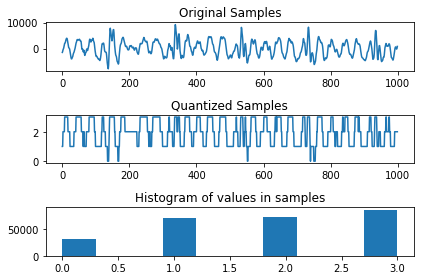

In [4]:
X = skimage.io.imread("alpaca.png")
fs, xblue = wavfile.read("blue.wav")
nlevels = 4
qxblue = quantize(xblue, nlevels)
plt.subplot(311)
plt.plot(xblue[5000:6000])
plt.title("Original Samples")
plt.subplot(312)
plt.plot(qxblue[5000:6000])
plt.title("Quantized Samples")
plt.subplot(313)
plt.hist(qxblue)
plt.tight_layout()
plt.title("Histogram of values in samples")
ipd.Audio(qxblue, rate=fs)

## Green Audio Quantization

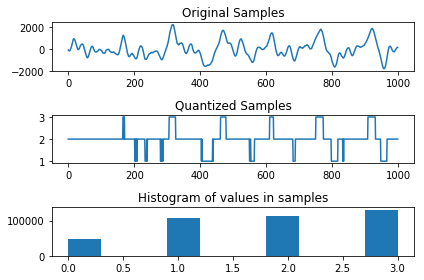

In [5]:
fs, xgreen = wavfile.read("green.wav")
qxgreen = quantize(xgreen, nlevels)
plt.subplot(311)
plt.plot(xgreen[5000:6000])
plt.title("Original Samples")
plt.subplot(312)
plt.plot(qxgreen[5000:6000])
plt.title("Quantized Samples")
plt.subplot(313)
plt.hist(qxgreen)
plt.title("Histogram of values in samples")
plt.tight_layout()
ipd.Audio(qxgreen, rate=fs)

## Red Audio

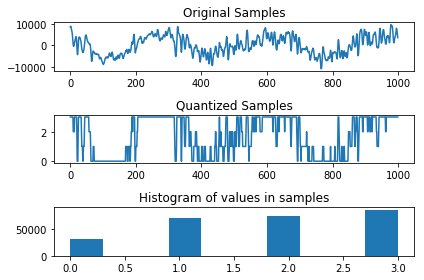

In [6]:
fs, xred = wavfile.read("red.wav")
qxred = quantize(xred, nlevels)
plt.subplot(311)
plt.plot(xred[5000:6000])
plt.title("Original Samples")
plt.subplot(312)
plt.plot(qxred[5000:6000])
plt.title("Quantized Samples")
plt.subplot(313)
plt.hist(qxred)
plt.title("Histogram of values in samples")
plt.tight_layout()
ipd.Audio(qxred, rate=fs)

## Create Image

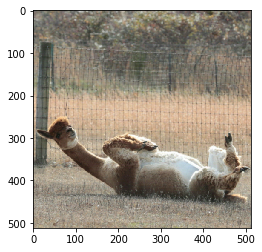

In [7]:
Y = np.array(X)
# Put each audio in the red, green, and blue channels
for k, qx in enumerate([qxred, qxgreen, qxblue]):
    x = np.array(qx.flatten(), dtype=np.uint8)
    # Take out the image channel and flatten it to get it
    # ready to put in audio
    y = Y[:, :, k].flatten()
    # Make sure the audio fits in the image
    x = x[0:min(x.size, y.size)]
    # Zero out the remainder in each pixel after dividing
    # by the number of levels, to make space for the audio
    y[0:x.size] -= np.mod(y[0:x.size], nlevels)
    # Add in the audio
    y[0:x.size] += x
    # Put the image channel back
    Y[:, :, k] = np.reshape(y, (Y.shape[0], Y.shape[1]))
plt.imshow(Y)
skimage.io.imsave("alpacastego.png", Y)

## MLK Example

In [11]:
nlevels = 4
X = skimage.io.imread("MLK.jpg")
fs, xfull = wavfile.read("mlk.wav")
xfull = quantize(xfull, nlevels)
ipd.Audio(xfull, rate=fs)

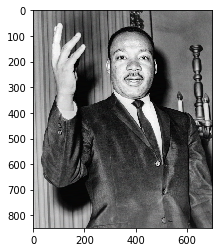

In [12]:
Y = np.array(X)
L = Y.shape[0]*Y.shape[1]
x1 = xfull[0:L]
x2 = xfull[L:2*L]
x3 = xfull[2*L::]
for k, qx in enumerate([x2, x3, x1]):
    x = np.array(qx.flatten(), dtype=np.uint8)
    y = Y[:, :, k].flatten()
    x = x[0:min(x.size, y.size)]
    y[0:x.size] -= np.mod(y[0:x.size], nlevels)
    y[0:x.size] += x
    Y[:, :, k] = np.reshape(y, (Y.shape[0], Y.shape[1]))
plt.imshow(Y)
skimage.io.imsave("MLKStego.png", Y)